In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
print(tf.__version__)

2.0.0


In [ ]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0],'GPU')# 设定只第一个GPU是可见的
tf.config.experimental.set_virtual_device_configuration(# 给GPU做逻辑切分
                gpus[0],# 制定使用哪个gpu
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
                tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
                tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
                tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),]
        )
print(len(gpus))
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(logical_gpus))



In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 584s 9us/step


In [5]:
print(PATH)

/Users/mac/.keras/datasets/cats_and_dogs_filtered


In [6]:
train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_va = len(os.listdir(valid_cats_dir))
num_dogs_va = len(os.listdir(valid_dogs_dir))
total_train = num_cats_tr + num_dogs_tr
total_valid = num_cats_va + num_dogs_va
print(num_cats_tr, num_dogs_tr, num_cats_va, num_dogs_va, total_train, total_valid)

1000 1000 500 500 2000 1000


In [8]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# 资料准备
## 在将图像馈送到网络之前，将图像格式化为经过适当预处理的浮点张量：

### 1、从磁盘读取图像。
### 2、解码这些图像的内容，并根据其RGB内容将其转换为正确的网格格式。
### 3、将它们转换为浮点张量。
### 4、将张量从0到255之间的值重新缩放为0到1之间的值，因为神经网络更喜欢处理较小的输入值。
### *幸运的是，所有这些任务都可以通过提供的ImageDataGenerator类来完成tf.keras。它可以从磁盘读取图像并将其预处理为适当的张量。它还将设置将这些图像转换成张量的生成器，这对于训练网络很有帮助。

In [14]:
# 初始化生成器
train_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# 在定义用于训练和验证图像的生成器之后，
# 该flow_from_directory方法从磁盘加载图像，应用重新缩放，然后将图像调整为所需的尺寸。
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                                                      directory = train_dir,
                                                                                      shuffle = True,
                                                                                      target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                                      class_mode = 'binary')
valid_data_gen = valid_image_generator.flow_from_directory(batch_size= batch_size,
                                                                                      directory = valid_dir,
                                                                                      target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                                      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
sample_training_images, _ = next(train_data_gen)#调用next返回一批(batch_size)数据
sample_training_images.shape

(128, 150, 150, 3)

In [17]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(5, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

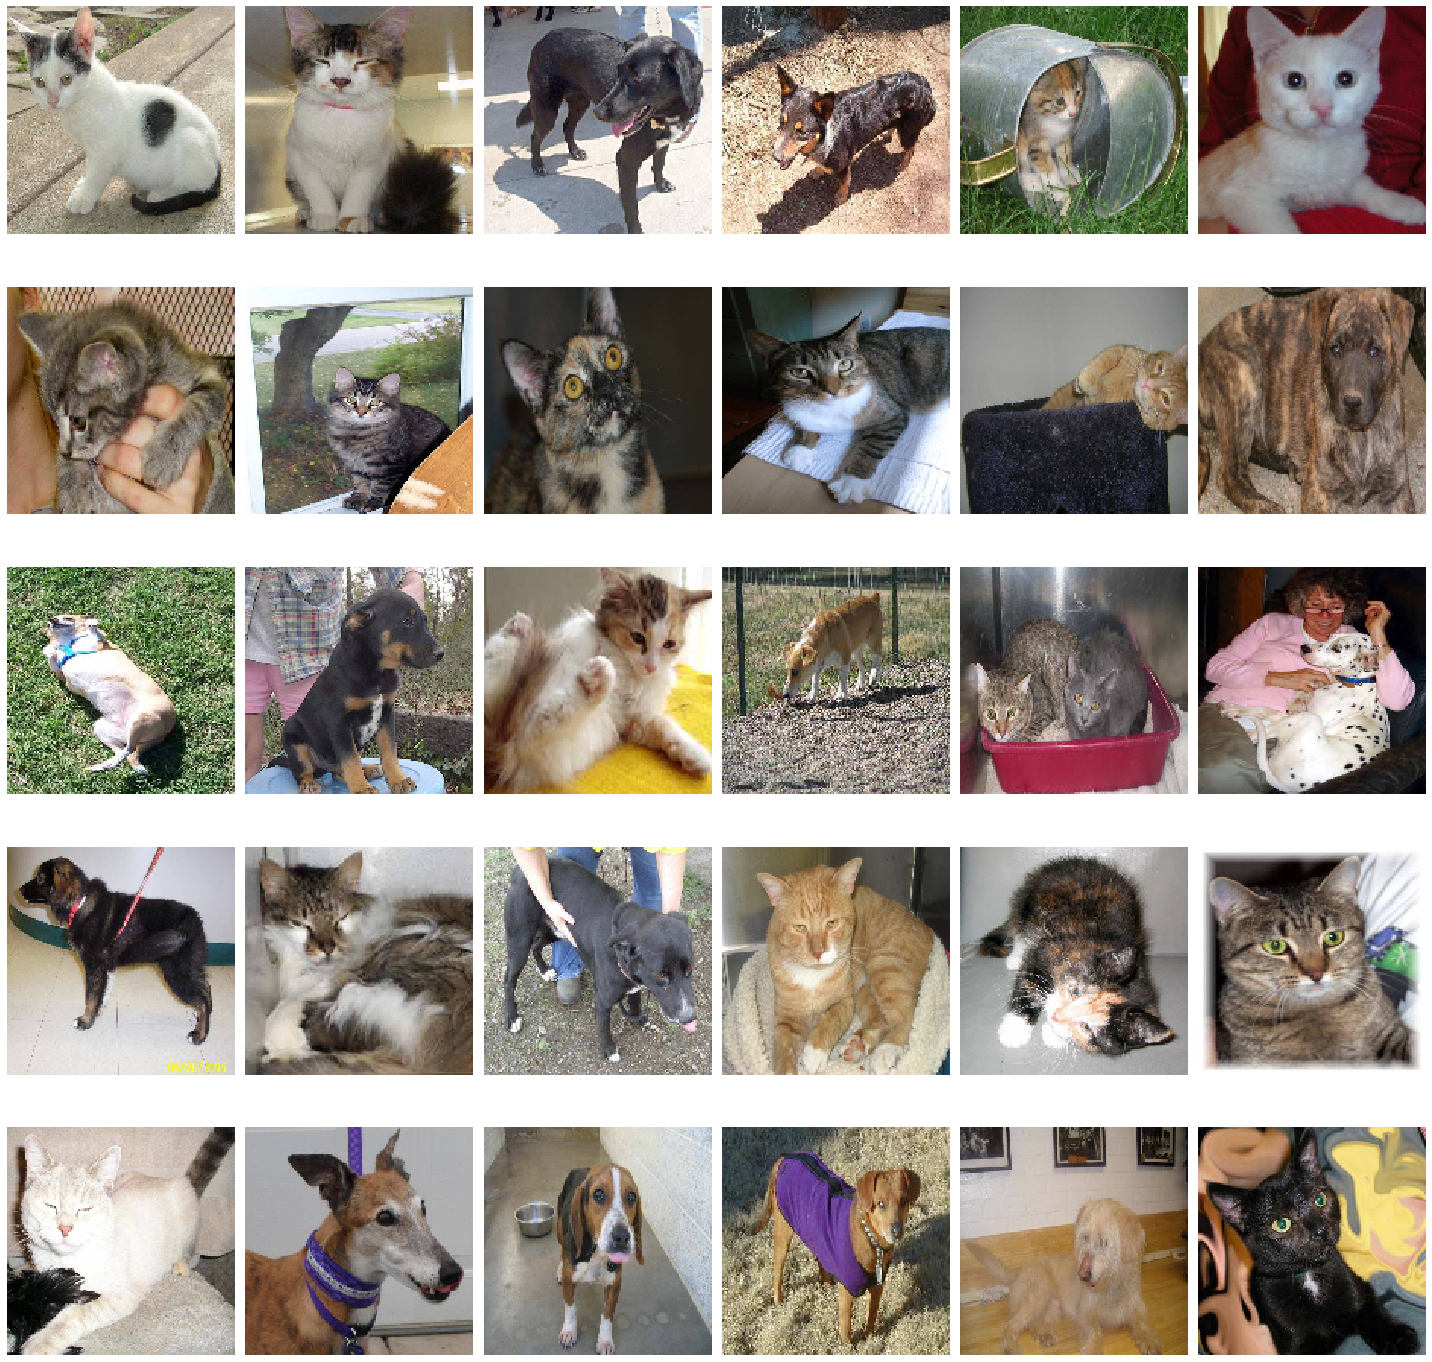

In [19]:
plotImages(sample_training_images[:30])

In [21]:
#实现多GPU分布式
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, 3, padding='same', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(256,activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                         optimizer = 'adam', metrics =['accuracy'] )


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

In [ ]:
history = model.fit_generator(train_data_gen,
                             steps_per_epoch = total_train // batch_size,
                             epochs = epochs,
                             validation_data = valid_data_gen,
                             validation_steps = total_valid // batch_size)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()